## Malaria cell classification

Classifying Malaria cell images as parasitized or uninfected

In [0]:
import os
import matplotlib.pyplot as plt
import cv2
import shutil
import random

In [0]:
from google.colab import files
uploaded = files.upload()

## Loading dataset from kaggle
[Guide](https://stackoverflow.com/questions/49310470/using-kaggle-datasets-in-google-colab)
Refer this guide for accesing kaggle dataset using API

In [0]:
!pip install -q kaggle
!pip install -q kaggle-cli

In [0]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then copy kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

In [0]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

## Unzip dataset

In [0]:
file_name='cell-images-for-detecting-malaria.zip'
from zipfile import ZipFile
with ZipFile(file_name, 'r') as zip_ref:
  zip_ref.extractall()

print('Extract completed!')
!ls

In [0]:
parasitized=os.listdir('cell_images/Parasitized')
uninfected=os.listdir('cell_images/Uninfected')

### Visualizing  Instances from Data set

#### Infected Cells

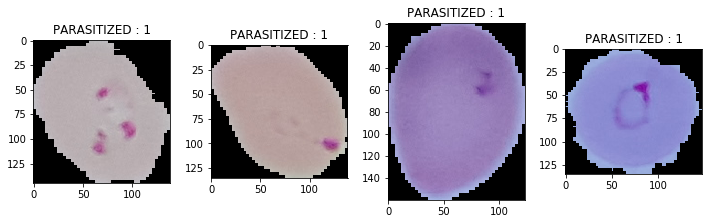

In [0]:
plt.figure(figsize = (10,10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    x=random.randint(0,len(parasitized))

    img = cv2.imread('cell_images/Parasitized' + "/" + parasitized[x])
    plt.imshow(img)
    plt.title('PARASITIZED : 1')
    plt.tight_layout()
plt.show()

### Uninfected cells

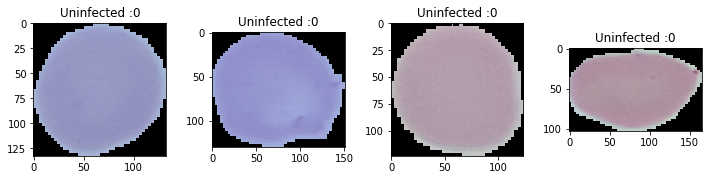

In [0]:
plt.figure(figsize = (10,10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    x=random.randint(0,len(uninfected))

    img = cv2.imread('cell_images/Uninfected' + "/" +uninfected[x])
    plt.imshow(img)
    plt.title('Uninfected :0')
    plt.tight_layout()
plt.show()

#### It is evident from observation that parasitized cells have clots present in them and  uninfected cells are without any clots 

### Spliting images to train and validation and test set

In [0]:
!pip install split-folders

import split_folders
orig_path = '/content/cell_images/'
output_path = '/content/dataset/'
split_folders.ratio(orig_path, output=output_path, seed=1, ratio=(.80, .15,.05))

Copying files: 27560 files [00:07, 3674.76 files/s]


In [0]:
train=os.listdir('/content/dataset/train/Parasitized')
val=os.listdir('/content/dataset/val/Uninfected')
test1=os.listdir('/content/dataset/test/Parasitized')
print('Train set size:',2*len(train))
print('Validation set size:',2*len(val))
print('Test set size:',2*len(test1))

Train set size: 22048
Validation set size: 4134
Test set size: 1378


## Training Colnvolution Neural network for classifying images 

In [0]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation,GlobalAveragePooling2D
from keras import callbacks
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K 
from keras.initializers import glorot_uniform
from keras.regularizers import l2
import scipy.misc
import matplotlib.pyplot  as plt

In [0]:
train_data_path = '/content/dataset/train'
validation_data_path = '/content/dataset/val'


In [0]:
img_width=80
img_height =80
batch_size = 32
samples_per_epoch = 1000
validation_steps = 32
no_filters1 = 32
no_filters2 = 64
no_filters3=128
conv1_size = 3
conv2_size = 5
conv3_size=7
pool_size = 2
classes_num = 2
lr = 0.005
epochs=100

### Preparing dataset for training network

In [0]:
train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  vertical_flip=True, 
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  fill_mode = 'nearest',
                                  zoom_range = 0.2,
                                  rotation_range = 10)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 22046 images belonging to 2 classes.
Found 4134 images belonging to 2 classes.


### Defining CNN Model Architecutre

In [0]:
model = Sequential()
model.add(Conv2D(filters=no_filters1,kernel_size=(7,7), border_mode ="same",data_format='channels_last', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization(axis = 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size),data_format='channels_last'))

model.add(Conv2D(filters=no_filters2,kernel_size=(5,5), border_mode ="same",data_format='channels_last'))
model.add(BatchNormalization(axis = 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size),data_format='channels_last'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=no_filters3,kernel_size=(3,3), border_mode ="same",data_format='channels_last'))
model.add(BatchNormalization(axis = 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size),data_format='channels_last'))
model.add(Dropout(0.2))

model.add(Conv2D(filters=no_filters3,kernel_size=(3,3), border_mode ="same",data_format='channels_last'))
model.add(BatchNormalization(axis = 3))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size),data_format='channels_last'))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())
#model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(32))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
epochs = 50

#sgd = optimizers.SGD(lr=lr, momentum=momentum, decay=decay_rate, nesterov=False)
adam = optimizers.Adam(lr=lr, beta_1=0.85, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=32, kernel_size=(7, 7), data_format="channels_last", input_shape=(80, 80, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=64, kernel_size=(5, 5), data_format="channels_last", padding="same")`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=128, kernel_size=(3, 3), data_format="channels_last", padding="same")`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(filters=128, kernel_size=(3, 3), data_format="channels_last", padding="same")`


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 80, 80, 32)        4736      
_________________________________________________________________
batch_normalization_21 (Batc (None, 80, 80, 32)        128       
_________________________________________________________________
activation_33 (Activation)   (None, 80, 80, 32)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 40, 40, 64)        51264     
_________________________________________________________________
batch_normalization_22 (Batc (None, 40, 40, 64)        256       
_________________________________________________________________
activation_34 (Activation)   (None, 40, 40, 64)       

In [0]:

target_dir = './models'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)


In [0]:

log_dir = './tf-log/'
tb_cb = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0)
file_path= "models/best_weights{epoch:03d}.h5"
chkpt=callbacks.ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
lr_red=callbacks.ReduceLROnPlateau(monitor = "val_acc", factor = 0.1, patience = 5,
  verbose = 1, mode = "auto", cooldown = 0,
  min_lr = 1e-30)

cbks = [tb_cb,chkpt,lr_red]

In [0]:

history=model.fit_generator(
    train_generator,
    steps_per_epoch=732,
    epochs=100,
    validation_data=validation_generator,
    callbacks=cbks,
    validation_steps=32)



Epoch 1/100
732/732 [==============================] - 79s 108ms/step - loss: 0.4677 - acc: 0.7613 - val_loss: 0.1597 - val_acc: 0.9561
Epoch 2/100
732/732 [==============================] - 76s 103ms/step - loss: 0.2258 - acc: 0.9374 - val_loss: 0.1275 - val_acc: 0.9600
Epoch 3/100
732/732 [==============================] - 76s 104ms/step - loss: 0.2021 - acc: 0.9424 - val_loss: 0.1612 - val_acc: 0.9443
Epoch 4/100
732/732 [==============================] - 75s 103ms/step - loss: 0.2038 - acc: 0.9448 - val_loss: 0.1456 - val_acc: 0.9561
Epoch 5/100
732/732 [==============================] - 75s 103ms/step - loss: 0.1933 - acc: 0.9459 - val_loss: 0.1345 - val_acc: 0.9559
Epoch 6/100
732/732 [==============================] - 75s 102ms/step - loss: 0.1874 - acc: 0.9454 - val_loss: 0.1506 - val_acc: 0.9473
Epoch 7/100
732/732 [==============================] - 75s 103ms/step - loss: 0.1911 - acc: 0.9448 - val_loss: 0.1385 - val_acc: 0.9648
Epoch 8/100
732/732 [===========================

In [0]:
target_dir = './models2'
if not os.path.exists(target_dir):
  os.mkdir(target_dir)
model.save('models2/Malaria_model.h5')


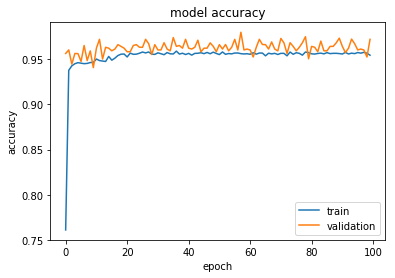

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

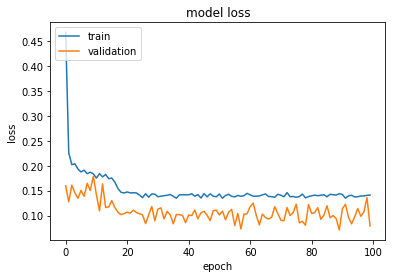

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Evaluating Model performance on test set

1) Loading Model with lowest error:
on Epoch number 58 we got highest validation accuracy hence, using that model on test data

In [0]:
from keras.models import load_model
from keras.preprocessing import image

In [0]:
model_final=load_model('./models2/Malaria_model.h5')
model_final.load_weights('./models/best_weights058.h5')

### Testing model on Parasitized images from test set

In [0]:
p=0
fail=0
i=1
error=[]
parasitized_test=os.listdir('dataset/test/Parasitized')
print('total parasitized imagesi test set:',len(parasitized_test))
for imdir in parasitized_test:
  img_path='./dataset/test/Parasitized/'+imdir
  img = image.load_img(img_path, target_size=(80, 80))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)        
  img_tensor /= 255. 
  pred = model_final.predict(img_tensor)
  classes = np.argmax(pred) 
  if classes==1:
    p=p+1
    error.append(img_path)

  else:
    fail+=1
  i+=1
                    

total parasitized imagesi test set: 689


In [0]:
print('Parasitized images classifed as parasitized:',fail)
print('Parasitized images classifed as uninfected:',p)


Parasitized images classifed as parasitized: 653
Parasitized images classifed as uninfected: 36


### Testing model on Uninfected images from test set

In [0]:
passed=0
failed=0
i=1
error_2=[]
parasitized_test=os.listdir('./dataset/test/Uninfected')
print('total uninfected images in test set:',len(parasitized_test))
for imdir in parasitized_test:
  img_path='./dataset/test/Uninfected/'+imdir
  img = image.load_img(img_path, target_size=(80,80))
  img_tensor = image.img_to_array(img)
  img_tensor = np.expand_dims(img_tensor, axis=0)        
  img_tensor /= 255. 
  pred = model_final.predict(img_tensor)
  classes = np.argmax(pred) 
  if classes==1:
    passed=passed+1
    error_2.append(img_path)

  else:
    failed+=1
  i+=1
                    

total uninfected images in test set: 689


In [0]:
print('Uninfected images classifed as parasitized:',failed)
print('Uninfected images classifed as uninfected:',passed)


Uninfected images classifed as parasitized: 26
Uninfected images classifed as uninfected: 663


In [0]:
model_accuracy=(fail+passed)/(2*689)
print('Accuracy of Model on test set :',model_accuracy*100)


Accuracy of Model on test set : 95.50072568940493


### Visualizing misclassified Images

1) Parasitized images classified as Uninfected

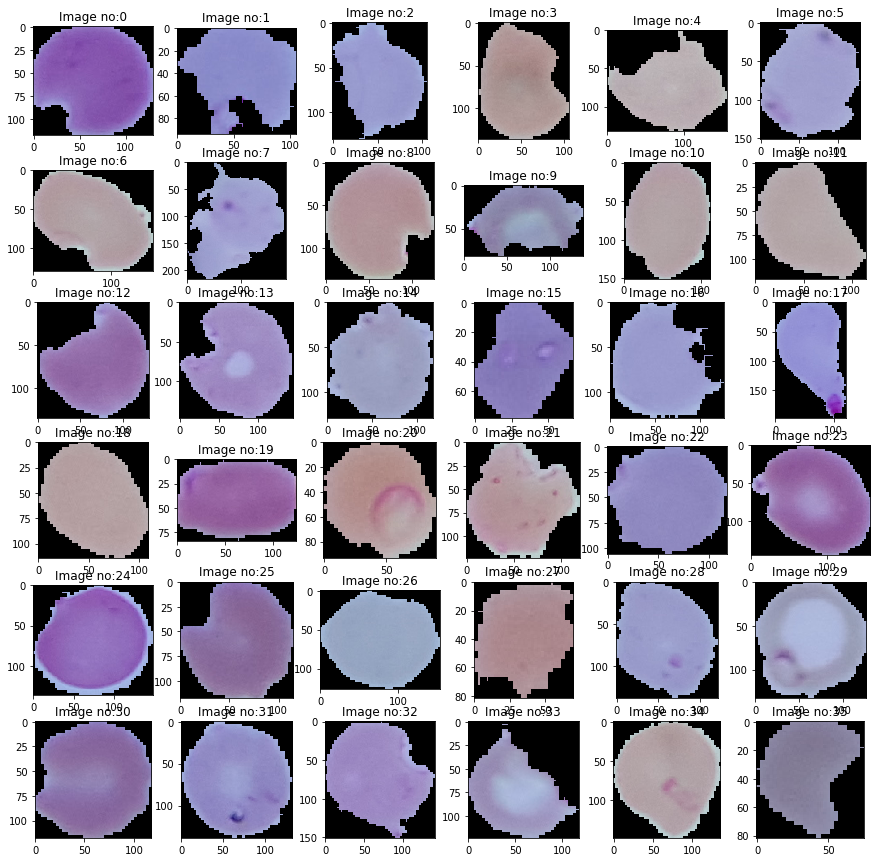

In [0]:

fig = plt.figure(figsize=(15, 15))
columns = 6
rows = 6


# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows):
    img = cv2.imread(error[i])
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("Image no:"+str(i))  # set title
    plt.imshow(img)

plt.show() 

2) Uninfected images classified as Parasitized 

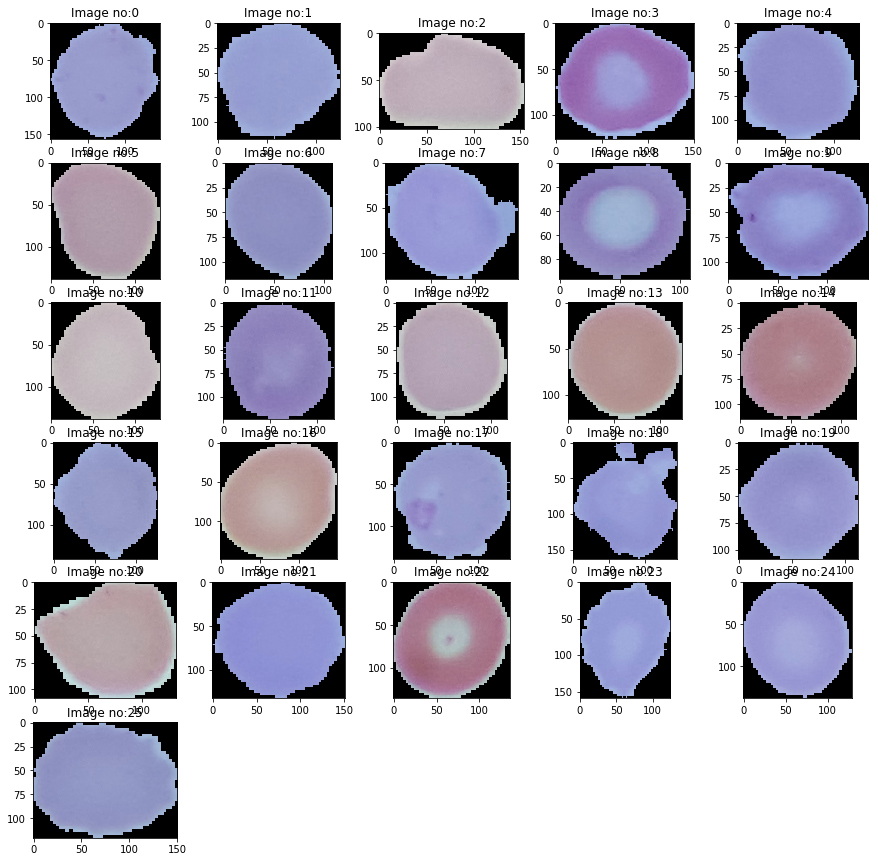

In [0]:
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 6


# ax enables access to manipulate each of subplots
ax = []

for i in range(columns*rows-4):
    img = cv2.imread(error_2[i])
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("Image no:"+str(i))  # set title
    plt.imshow(img)

plt.show() 

### WE can observe from misclassified images that some images were mislabelled which lead to misclassification